<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/UNet_Endonasal_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customized Segment Anything Model for Medical Image Segmentation
### [[Paper](https://arxiv.org/pdf/2304.13785.pdf)] [[Github](https://github.com/hitachinsk/SAMed)]
---


# Setup environment

In [1]:
!pip install -q gdown==4.6.0 einops==0.6.1 icecream==2.1.3 MedPy==0.4.0 monai==1.1.0 opencv_python==4.5.4.58 SimpleITK==2.2.1 tensorboardX==2.6 ml-collections==0.1.1 onnx==1.13.1 onnxruntime==1.14.1 tensorboardX torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 801.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

# Download codes, pretrained weights and test data

In [2]:
# prepare codes
import os
CODE_DIR = 'samed_codes'
os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/hitachinsk/SAMed.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')

Cloning into 'samed_codes'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 225 (delta 86), reused 72 (delta 72), pack-reused 123
Receiving objects: 100% (225/225), 635.01 KiB | 5.99 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [3]:
!gdown https://drive.google.com/uc?id=1bxPjOUm6CqKsQ8wdpUgXN0djF_hoO1Km

Downloading...
From: https://drive.google.com/uc?id=1bxPjOUm6CqKsQ8wdpUgXN0djF_hoO1Km
To: /content/samed_codes/Endonasal_Slices.zip
100% 152M/152M [00:00<00:00, 183MB/s]


In [4]:
%cd /content/samed_codes
#dataset
import zipfile
with zipfile.ZipFile('Endonasal_Slices.zip', 'r') as zip_ref:
    zip_ref.extractall()
#weights
!gdown https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr #'epoch_159.pth'
!gdown https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg #'sam_vit_b_01ec64.pth'

/content
Downloading...
From: https://drive.google.com/uc?id=1P0Bm-05l-rfeghbrT1B62v5eN-3A-uOr
To: /content/samed_codes/epoch_159.pth
100% 19.7M/19.7M [00:00<00:00, 56.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_oCdoEEu3mNhRfFxeWyRerOKt8OEUvcg
To: /content/samed_codes/sam_vit_b_01ec64.pth
100% 375M/375M [00:07<00:00, 51.2MB/s]


Dataloader:

/content
Train Sample: 798 Test Sample: 342
Unique classes: [0 1 2]
min-mas: -0.8220931744538053 5.4866124152057045


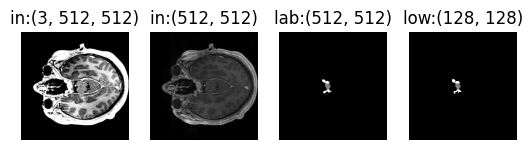

In [28]:
%cd /content/samed_codes
from torch.utils.data import Dataset, DataLoader
from glob import glob
import imageio.v2 as iio
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from scipy.ndimage import zoom
from einops import repeat
from scipy import ndimage
import random
from PIL import Image
import cv2

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    label = np.rot90(label, k)
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label


def random_rotate(image, label):
    angle = np.random.randint(-20, 20)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

def map_labels(label):
    label_map = {0: 0, 85: 1, 128:0, 170: 2, 255: 3}
    mapped_label = label.copy()
    for k, v in label_map.items():
        mapped_label[label == k] = v
    return mapped_label

class EndonasalDataset(Dataset):
    def __init__(self, root='endonasal_train', low_res=None, isTrain=False):
        self.img_path_all = glob(root + '/mri_t1c/*.png')  # Update the path and pattern
        # self.mask_path_all = glob(root + '/mri_masks/*.png')  # Update the path and pattern
        self.mask_path_all = [img_path.replace('mri_t1c', 'mri_masks') for img_path in self.img_path_all]
        self.isTrain = isTrain
        self.isTrain = isTrain
        self.low_res = low_res

    def __len__(self):
      return len(self.img_path_all)

    def __getitem__(self, index):
        image = iio.imread(self.img_path_all[index])
        image = normalise_intensity(image)
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)
        label = iio.imread(self.mask_path_all[index])
        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)
        if self.isTrain:
            if random.random() > 0.5:
                image, label = random_rot_flip(image, label)
            elif random.random() > 0.5:
                image, label = random_rotate(image, label)

        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label}

        return sample

train_dataset = EndonasalDataset(root='Endonasal_Slices/Train', low_res=128, isTrain=True)
test_dataset = EndonasalDataset(root='Endonasal_Slices/Test', low_res=128)
print('Train Sample:', len(train_dataset), 'Test Sample:', len(test_dataset))
sample = train_dataset[13]

input, label, low_res_label = np.array(sample['image']), sample['label'], sample['low_res_label']
print('Unique classes:', np.unique(low_res_label))
print('min-mas:',input.min(), input.max())
plt.subplot(1,4,1), plt.axis('OFF'), plt.title('in:{}'.format(input.shape)), plt.imshow(input.transpose(1,2,0))
plt.subplot(1,4,2), plt.axis('OFF'), plt.title('in:{}'.format(input[0].shape)), plt.imshow(input[0], cmap='gray')
plt.subplot(1,4,3), plt.axis('OFF'), plt.title('lab:{}'.format(label.shape)), plt.imshow(label, cmap='gray');
plt.subplot(1,4,4), plt.axis('OFF'), plt.title('low:{}'.format(low_res_label.shape)), plt.imshow(low_res_label, cmap='gray');

In [32]:
import monai
model = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    )

TypeError: got an unexpected keyword argument 'pretrained'

In [ ]:
!pip install

SAM Training

In [39]:
%cd /content/samed_codes
import os
import sys
from tqdm import tqdm
import logging
import numpy as np
import argparse
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from importlib import import_module
from segment_anything import sam_model_registry
from datasets.dataset_synapse import Synapse_dataset
from icecream import ic
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat

from torch.nn.modules.loss import CrossEntropyLoss
from utils import DiceLoss
import torch.optim as optim
import monai


def seed_everything(seed=42):
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def calc_loss(outputs, label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    loss_ce = ce_loss(outputs, label_batch[:].long())
    loss_dice = dice_loss(outputs, label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice

def training_per_epoch(model, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=True, args=None):
    model.train()
    loss_all = []
    for i_batch, sampled_batch in enumerate(trainloader):
        image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
        image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
        outputs = model(image_batch)
        # print('out:',outputs.shape)
        loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, ce_loss, dice_loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all.append(loss.item())
        if args.warmup and iter_num < args.warmup_period:
            lr_ = args.base_lr * ((iter_num + 1) / args.warmup_period)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_
        else:
            if args.warmup:
                shift_iter = iter_num - args.warmup_period
                assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
            else:
                shift_iter = iter_num
            lr_ = args.base_lr * (1.0 - shift_iter / args.max_iterations) ** 0.9  # learning rate adjustment depends on the max iterations
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_

        iter_num = iter_num + 1

    return np.mean(loss_all)


def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    loss_per_epoch, dice_per_epoch = [], []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch)
            loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
    return np.mean(loss_per_epoch), np.mean(dice_per_epoch)



def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=6, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.0005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=10, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.output_dir = 'results'
    os.makedirs(args.output_dir, exist_ok = True)

    # sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
    #                                                                 num_classes=args.num_classes,
    #                                                                 checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
    #                                                                 pixel_std=[1, 1, 1])

    # pkg = import_module(args.module)
    # net = pkg.LoRA_Sam(sam, args.rank).cuda()
    # net.load_lora_parameters(args.lora_ckpt)
    net = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=args.num_classes + 1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    multimask_output = True if args.num_classes > 1 else False
    train_dataset = EndonasalDataset(root='Endonasal_Slices/Train', low_res=128, isTrain=True)
    test_dataset = EndonasalDataset(root='Endonasal_Slices/Test', low_res=128)
    trainloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=2)
    print('Training on:', device, 'train sample size:', len(train_dataset), 'test sample size:', len(test_dataset), 'batch:', args.batch_size)

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)
    b_lr = args.base_lr / args.warmup_period
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, net.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    iter_num = 0

    best_epoch, best_loss = 0.0, np.inf
    for epoch in range(args.max_epochs):
        loss_training = training_per_epoch(net, trainloader, optimizer, iter_num, ce_loss, dice_loss, multimask_output=multimask_output, args=args)
        loss_testing, dice = test_per_epoch(net, testloader, ce_loss, dice_loss,multimask_output=True, args=args)

        if loss_testing < best_loss:
            best_loss = loss_testing
            best_epoch = epoch
            torch.save(net.state_dict(), os.path.join(args.output_dir, 'model_best.pt'))
            # net.save_lora_parameters(os.path.join(args.output_dir, 'model_best.pt'))

        print('--- Epoch {}\{}: Training loss = {:.4f}, Testing: [loss = {:.4f}, dice = {:.4f}], Best loss = {:.4f}, Best epoch = {}, lr = {:.6f}'.\
            format(epoch, args.max_epochs, loss_training, loss_testing, dice, best_loss, best_epoch, optimizer.param_groups[0]['lr']))


if __name__ == '__main__':
    seed_everything()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    main()



/content
Training on: cuda train sample size: 798 test sample size: 342 batch: 10
--- Epoch 0\10: Training loss = 0.8434, Testing: [loss = 0.8038, dice = 0.2343], Best loss = 0.8038, Best epoch = 0, lr = 0.000160
--- Epoch 1\10: Training loss = 0.7957, Testing: [loss = 0.7756, dice = 0.2470], Best loss = 0.7756, Best epoch = 1, lr = 0.000160
--- Epoch 2\10: Training loss = 0.7712, Testing: [loss = 0.7554, dice = 0.2566], Best loss = 0.7554, Best epoch = 2, lr = 0.000160
--- Epoch 3\10: Training loss = 0.7518, Testing: [loss = 0.7363, dice = 0.2659], Best loss = 0.7363, Best epoch = 3, lr = 0.000160
--- Epoch 4\10: Training loss = 0.7324, Testing: [loss = 0.7130, dice = 0.2775], Best loss = 0.7130, Best epoch = 4, lr = 0.000160
--- Epoch 5\10: Training loss = 0.7077, Testing: [loss = 0.6859, dice = 0.2909], Best loss = 0.6859, Best epoch = 5, lr = 0.000160
--- Epoch 6\10: Training loss = 0.6823, Testing: [loss = 0.6631, dice = 0.3016], Best loss = 0.6631, Best epoch = 6, lr = 0.000160
-

Inference: My Dice Metrics

Class Wise Dice: {'dice_cls:1': 0.9366549680685806, 'dice_cls:2': 0.023070097604259095}
Overall Dice: 0.47986253283641983


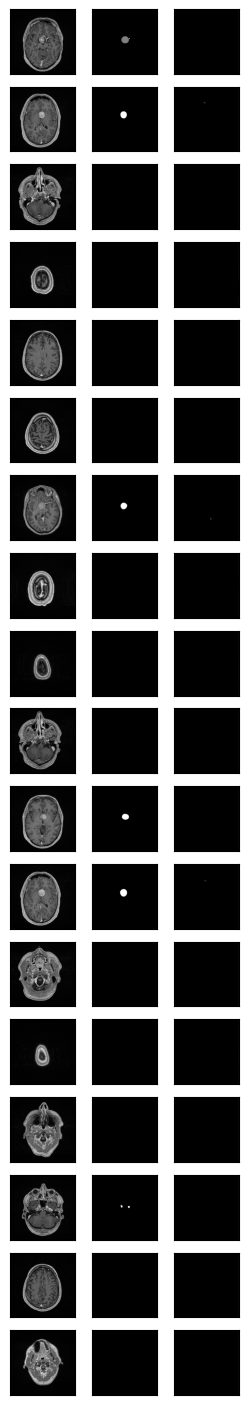

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    fig, axs = plt.subplots(len(testloader), 3, figsize=(1*3, len(testloader)*1), subplot_kw=dict(xticks=[],yticks=[]))
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            logits = model(image_batch)
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(logits, label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            loss_dice = dice_loss(logits, label_batch, softmax=True)
            img_num = 0
            axs[i_batch, 0].imshow(image_batch[img_num, 0].cpu().numpy(), cmap='gray')
            axs[i_batch, 1].imshow(label_batch[img_num].cpu().numpy(), cmap='gray')
            axs[i_batch, 2].imshow(pred_seg[img_num].cpu().numpy(), cmap='gray')
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): dice
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class



if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=12, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.ckpt = 'results/model_best.pt'
    net = monai.networks.nets.UNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=args.num_classes + 1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)

    net.load_state_dict(torch.load(args.ckpt))
    testloader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)
    test_loss, overall_dice, dices_per_class = test_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
    dices_per_class_list = np.array(list(dices_per_class.values()))
    print('Class Wise Dice:', dices_per_class)
    print('Overall Dice:', np.mean(dices_per_class_list))

Inference MRI to MRI<br>
download test mri

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1zcvnBscFVI2v5ieAlGGnp0zpX8WmIrD4'
gdown.download(url,'endonasal_mri_patients.zip',quiet=True)
!unzip -q endonasal_mri_patients
!rm -rf /content/endonasal_mri_patients/.DS_Store
!rm -rf /content/endonasal_mri_patients/**/.DS_Store

MRI to MRI

In [ ]:
import os
import nibabel as nib
import cv2
import numpy as np
from scipy.ndimage import zoom
from einops import repeat
import random
import matplotlib.pyplot as plt
import numpy as np

def read_mri(mri_path):
    img_meta = nib.load(mri_path)
    array = img_meta.get_fdata()
    return np.rot90(array)

def normalise_intensity(image, ROI_thres=0.1):
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean) / (std + 1e-8) # Normalise ROI
    return ROI_norm

class EndonasalDataset_MRI(Dataset):
    def __init__(self, root='endonasal_mri_patients', patient=None, low_res=None, isTrain=False):

        mri_path = 'endonasal_mri_patients/mri0{}/mri0{}_t1c.nii.gz'.format(patient, patient)
        self.mask_path = 'endonasal_mri_patients/mri0{}/mri0{}_mask.nii.gz'.format(patient, patient)
        mri_array = read_mri(mri_path)
        self.image_all = []
        for z in range(mri_array.shape[2]):
            normalized_slice = cv2.normalize(mri_array[:, :, z], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            self.image_all.append(normalise_intensity(normalized_slice))

        self.mask_all = read_mri(self.mask_path)
        self.isTrain = isTrain
        self.low_res = low_res

    def __len__(self):
      return len(self.image_all)

    def __getitem__(self, index):
        image = self.image_all[index]
        image = zoom(image, (512/image.shape[0], 512/image.shape[1]), order=0)
        label = self.mask_all[:,:,index]
        label = zoom(label, (512/label.shape[0], 512/label.shape[1]), order=0)
        if self.isTrain:
            if random.random() > 0.5:
                image, label = random_rot_flip(image, label)
            elif random.random() > 0.5:
                image, label = random_rotate(image, label)

        image = repeat(np.expand_dims(image, axis=0), 'c h w -> (repeat c) h w', repeat=3)
        sample = {'image': image, 'label': label}
        if self.low_res:
            low_res_label = zoom(label, (self.low_res/label.shape[0], self.low_res/label.shape[1]), order=0)
            sample = {'image': image, 'label': label, 'low_res_label': low_res_label, 'maskpath': self.mask_path}

        return sample


def calculate_confusion_matrix_from_arrays(prediction, ground_truth, nr_labels):
    replace_indices = np.vstack((
        ground_truth.flatten(),
        prediction.flatten())
    ).T
    confusion_matrix, _ = np.histogramdd(
        replace_indices,
        bins=(nr_labels, nr_labels),
        range=[(0, nr_labels), (0, nr_labels)]
    )
    confusion_matrix = confusion_matrix.astype(np.uint32)
    return confusion_matrix

def calculate_dice(confusion_matrix):
    dices = []
    for index in range(confusion_matrix.shape[0]):
        true_positives = confusion_matrix[index, index]
        false_positives = confusion_matrix[:, index].sum() - true_positives
        false_negatives = confusion_matrix[index, :].sum() - true_positives
        denom = 2 * true_positives + false_positives + false_negatives
        if denom == 0:
            dice = 0
        else:
            dice = 2 * float(true_positives) / denom
        dices.append(dice)
    return dices

def pred_to_mri(pred_seg_all, mask_path):
    os.makedirs('predicted_mri', mode = 0o777, exist_ok = True)
    img_meta = nib.load(mask_path)
    pred_seg_all = np.rot90(np.array(pred_seg_all).transpose(1,2,0), k=-1)
    img_nifti = nib.Nifti1Image(pred_seg_all, img_meta.affine, header=img_meta.header)
    nib.save(img_nifti,'predicted_mri/'+os.path.basename(mask_path))

def test_per_epoch(model, testloader, ce_loss, dice_loss, multimask_output=True, args=None):
    model.eval()
    loss_per_epoch, dice_per_epoch = [], []
    num_classes = args.num_classes + 1
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    class_wise_dice = []
    pred_seg_all = []
    with torch.no_grad():
        for i_batch, sampled_batch in enumerate(testloader):
            image_batch, label_batch, low_res_label_batch = sampled_batch['image'],sampled_batch['label'], sampled_batch['low_res_label']
            image_batch, label_batch, low_res_label_batch = image_batch.to(device, dtype=torch.float32), label_batch.to(device, dtype=torch.long), low_res_label_batch.to(device, dtype=torch.long)
            outputs = model(image_batch, multimask_output, args.img_size)
            logits = outputs['masks']
            prob = F.softmax(logits, dim=1)
            pred_seg = torch.argmax(prob, dim=1)
            pred_seg_all.extend(pred_seg.detach().cpu().numpy())
            confusion_matrix += calculate_confusion_matrix_from_arrays(pred_seg.cpu(), label_batch.cpu(), num_classes)
            loss, loss_ce, loss_dice = calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss)
            loss_per_epoch.append(loss.item())
            dice_per_epoch.append(1-loss_dice.item())
            low_res_logits = outputs['low_res_logits']
            loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
            metric_list = []
            pred_seg, label_batch = pred_seg.cpu().detach().numpy(), label_batch.cpu().detach().numpy()

        pred_to_mri(np.array(pred_seg_all), sampled_batch['maskpath'][0])
        confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
        dices_per_class = {'dice_cls:{}'.format(cls + 1): round(dice, 4)
                    for cls, dice in enumerate(calculate_dice(confusion_matrix))}

    return np.mean(loss_per_epoch), np.mean(dice_per_epoch), dices_per_class



if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, help='The config file provided by the trained model')
    parser.add_argument('--volume_path', type=str, default='testset/test_vol_h5/')
    parser.add_argument('--dataset', type=str, default='Synapse', help='Experiment name')
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--list_dir', type=str, default='./lists/lists_Synapse/', help='list_dir')
    parser.add_argument('--output_dir', type=str, default='results')
    parser.add_argument('--img_size', type=int, default=512, help='Input image size of the network')
    parser.add_argument('--input_size', type=int, default=224, help='The input size for training SAM model')
    parser.add_argument('--seed', type=int,
                        default=1234, help='random seed')
    parser.add_argument('--is_savenii', action='store_true', help='Whether to save results during inference')
    parser.add_argument('--deterministic', type=int, default=1, help='whether use deterministic training')
    parser.add_argument('--ckpt', type=str, default='checkpoints/sam_vit_b_01ec64.pth',
                        help='Pretrained checkpoint')
    parser.add_argument('--lora_ckpt', type=str, default='checkpoints/epoch_159.pth', help='The checkpoint from LoRA')
    parser.add_argument('--vit_name', type=str, default='vit_b', help='Select one vit model')
    parser.add_argument('--rank', type=int, default=4, help='Rank for LoRA adaptation')
    parser.add_argument('--module', type=str, default='sam_lora_image_encoder')

    parser.add_argument('--base_lr', type=float, default=0.005, help='segmentation network learning rate')
    parser.add_argument('--batch_size', type=int, default=12, help='batch_size per gpu')
    parser.add_argument('--warmup', type=bool, default=True, help='If activated, warp up the learning from a lower lr to the base_lr')
    parser.add_argument('--warmup_period', type=int, default=250, help='Warp up iterations, only valid whrn warmup is activated')
    parser.add_argument('--AdamW', type=bool, default=True, help='If activated, use AdamW to finetune SAM model')
    parser.add_argument('--max_epochs', type=int, default=10, help='maximum epoch number to train')
    parser.add_argument('--max_iterations', type=int, default=30000, help='maximum epoch number to train')


    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    args.ckpt = 'sam_vit_b_01ec64.pth'
    args.lora_ckpt = 'results/model_best.pt'
    sam, img_embedding_size = sam_model_registry[args.vit_name](image_size=args.img_size,
                                                                    num_classes=args.num_classes,
                                                                    checkpoint=args.ckpt, pixel_mean=[0, 0, 0],
                                                                    pixel_std=[1, 1, 1])

    pkg = import_module(args.module)
    net = pkg.LoRA_Sam(sam, args.rank).cuda()
    ce_loss = CrossEntropyLoss()
    dice_loss = DiceLoss(args.num_classes + 1)

    assert args.lora_ckpt is not None
    net.load_lora_parameters(args.lora_ckpt)

    patients = ['154', '169', '170']
    mean_overall = []
    tumor_overall = []
    carotid_overall = []
    for patient in patients:
        test_dataset = EndonasalDataset_MRI(root='endonasal_mri_patients', patient=patient, low_res=128)
        testloader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=2)
        test_loss, overall_dice, dices_per_class = test_per_epoch(net, testloader, ce_loss, dice_loss, multimask_output=True, args=args)
        dices_per_class_list = np.array(list(dices_per_class.values()))
        overall = round(np.mean(dices_per_class_list),4)
        mean_overall.append(overall)
        tumor_overall.append(dices_per_class['dice_cls:1'])
        carotid_overall.append(dices_per_class['dice_cls:2'])
        print('Patient:', patient, ',Class Wise:', dices_per_class, ',Overall :', overall)

    print('Overall Model Performance [Mean Overall]:', round(np.mean(mean_overall),4), '[cls-1:{}]'.format(round(np.mean(tumor_overall),4)),\
            '[cls-2:{}]'.format(round(np.mean(carotid_overall),4)))


Patient: 154 ,Class Wise: {'dice_cls:1': 0.9737, 'dice_cls:2': 0.7039} ,Overall : 0.8388
Patient: 169 ,Class Wise: {'dice_cls:1': 0.991, 'dice_cls:2': 0.9621} ,Overall : 0.9766
Patient: 170 ,Class Wise: {'dice_cls:1': 0.9894, 'dice_cls:2': 0.8928} ,Overall : 0.9411
Overall Model Performance [Mean Overall]: 0.9188 [cls-1:0.9847] [cls-2:0.8529]


Post Processing to remove outliers (small seg)

In [ ]:
from skimage import morphology
import nibabel as nib
mask_meta = nib.load('/content/samed_codes/endonasal_mri_patients/mri0169/mri0169_mask.nii.gz')
mask = nib.load('/content/samed_codes/predicted_mri/mri0169_mask.nii.gz').get_fdata()

binary_mask = morphology.remove_small_objects(mask>0, 50)
mask[binary_mask==0] = 0
img_nifti = nib.Nifti1Image(mask, mask_meta.affine, header=mask_meta.header)
nib.save(img_nifti,'mri0169_mask_post_processed.nii.gz')